In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Realizations generated with best case for hist reproduction"
nb_name = "nb_seqsim_core_sh30_histrep"

# Core

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)


In [3]:
core.generate_map(target_var_factor = 1)

In [4]:
#core.data = core.data - np.mean(core.data)

In [5]:
#mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
#                            data=core.data, point_size=10, shift_grid = True, 
#                            transpose_grid = True, shape = (121,61), cmap = 'PuOr_r', 
#                            title="Prior radial lithosphere information")

In [6]:
core.condtab(normsize=100, quantiles = 10, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101)

In [73]:
core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True)

keep_sv_curve = core.sv_curve.copy()
keep_lags_sv_curve = core.lags_sv_curve.copy()

C_e_const = 2.0

#nugget = C_e_const**2
#nugget_p = 0.01
#var_fac = 0.1

#set_model = {"a": 2000, "C0": var_fac*core.target_var*nugget_p, "C1": var_fac*core.target_var*(1-nugget_p), "C2": None, "C3": None}
#set_model = {"a": 1800, "C0": nugget, "C1": var_fac*core.target_var-nugget, "C2": None, "C3": None}

set_model = {"a": 1700, "C0": 0.0, "C1": core.target_var, "C2": None, "C3": None}


#set_model = {"a": 200, "C0": 0.0, "C1": 0.15*core.target_var,
#             "C2": core.target_var-0.15*core.target_var, "C3": 20000}


#core.semivar(model_lags = "all", model = "dub_spherical", max_dist = 20000, lag_length = 200,
#             zero_nugget = True, hit_target_var = True, set_model = set_model)

core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True, set_model = set_model)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


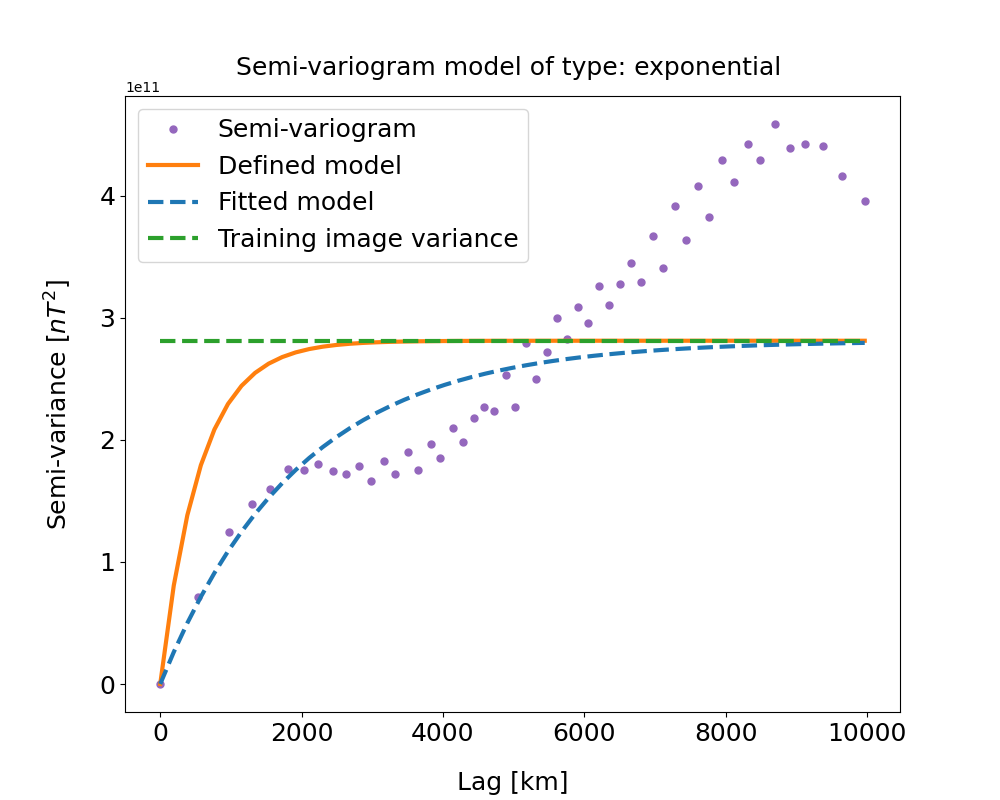

In [84]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1', linewidth = 3,label='Defined model')
plt.plot(keep_lags_sv_curve,keep_sv_curve,"--",color='C0',linewidth = 3,label='Fitted model')

plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3,
         color="C2", linestyle="dashed", label="Training image variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [8]:
#print(core)

# Synthetic sat

In [9]:
s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)

In [10]:
s_sat.generate_map(grid_type = "swarm")

In [11]:
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [12]:
#mt_util.plot_cartopy_global(lat = s_sat.lat, lon = s_sat.lon, plot_quality = "high", point_size=5, 
#                            data=s_sat.data, cmap = 'PuOr_r', title="Synthetic satellite data")

In [13]:
#print(s_sat)

# Source truth

In [14]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations


Gauss-Legendre RMSE:	 14351.277096124773


<IPython.core.display.Javascript object>


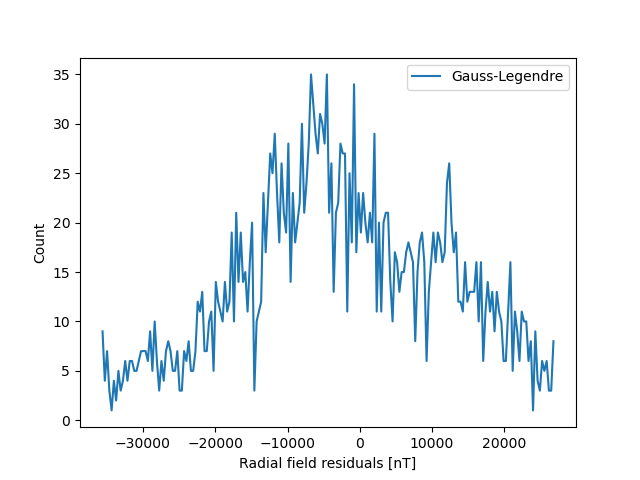

In [15]:
core.integrating_kernel(s_sat, C_e_const = C_e_const)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 7.777 minutes 
Total elapsed time: 7.777 minutes 
Variance: 285752168101.785
Mean: -32868.231
Max: 2813427.395
Min: -1701738.419
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.962 minutes 
Total elapsed time: 16.739 minutes 
Variance: 310065867213.947
Mean: -16703.892
Max: 2797839.808
Min: -1626866.731
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.426 minutes 
Total elapsed time: 27.165 minutes 
Variance: 279506580100.605
Mean: -26754.231
Max: 2711433.386
Min: -1718131.126
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 10.333 minutes 
Total elapsed time: 37.498 minutes 
Variance: 293319057561.850
Mean: -17630.836
Max: 2776325.273
Min: -1671104.441
Run nr.: 4


Seqsim RMSE:	 [[1.98854263

<IPython.core.display.Javascript object>


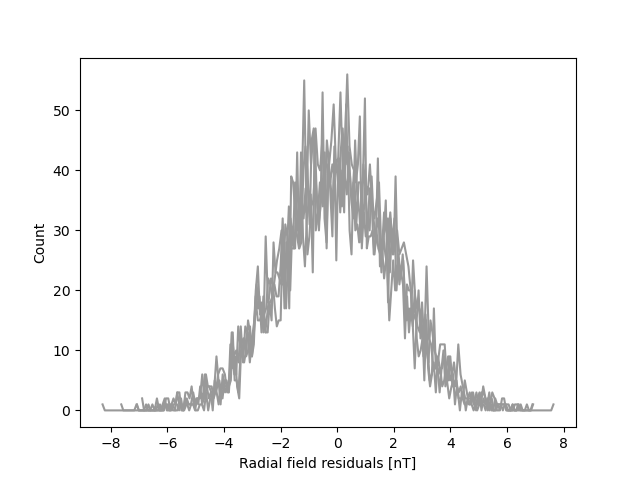

In [16]:
N_sim = 4

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [17]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_g)

In [18]:
core.covmod_lsq_equiv(s_sat.data, core.C_mm_all, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


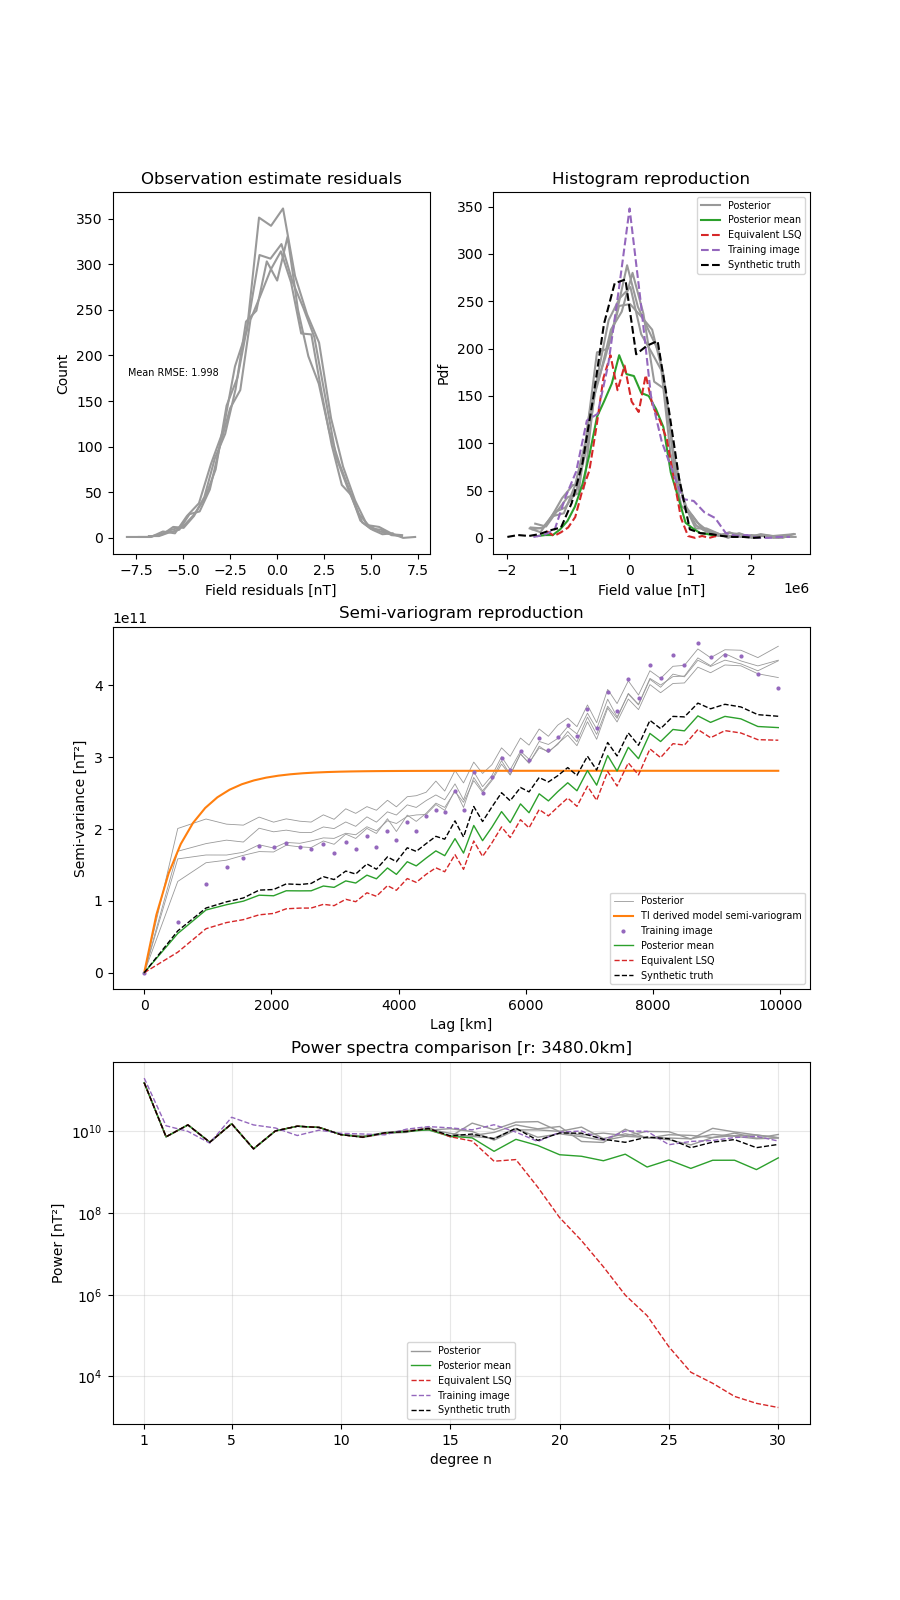

In [90]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "core_sh30_tryfit", save_dpi = 300)

In [20]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_g

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


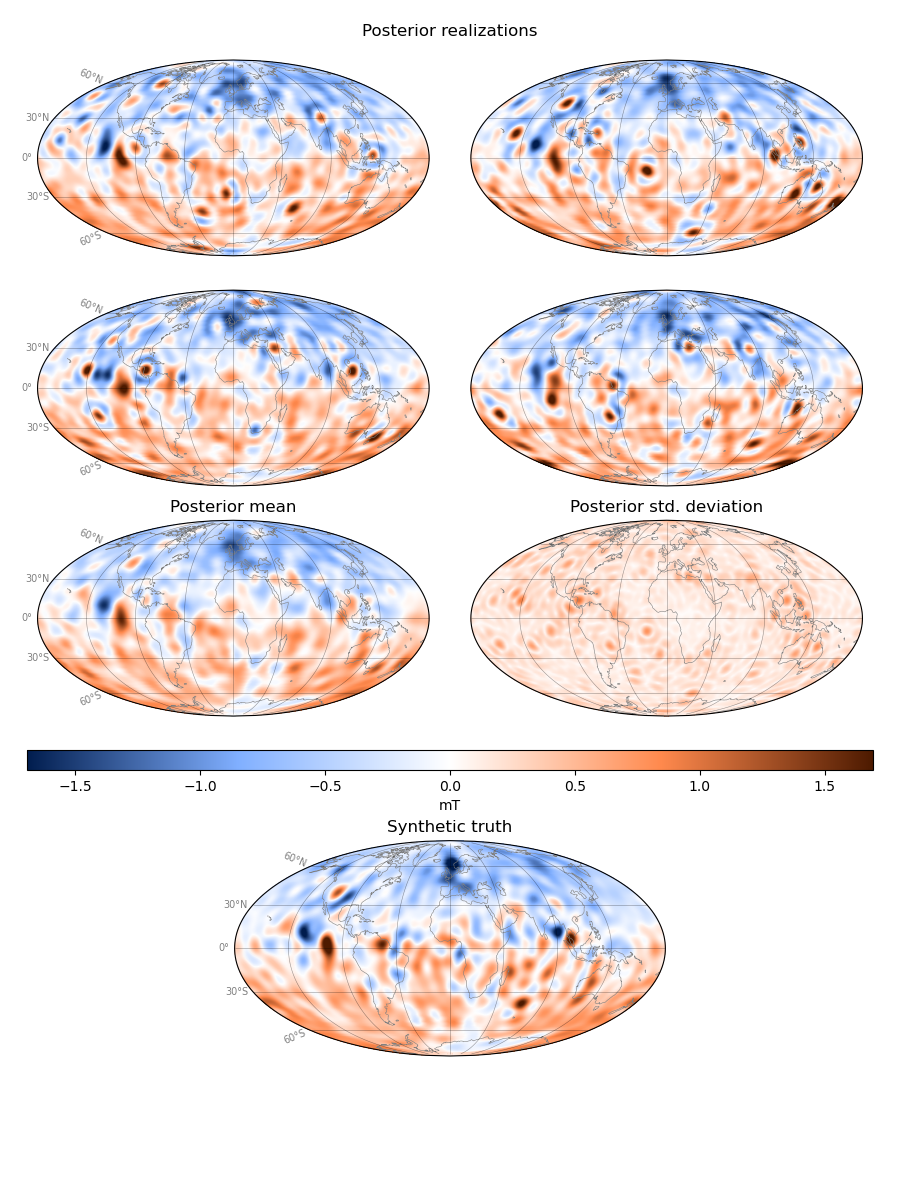

In [25]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_tryfit", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


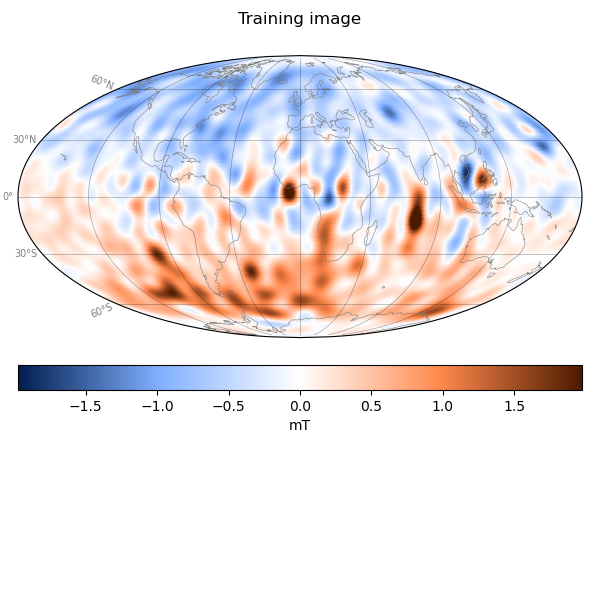

In [71]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [23]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")